In [1]:
import numpy as np
import openpiv

from matplotlib import pyplot as plt

In [2]:
# this syhnthetic image pair has a velocity of 1.5 pxels.
# I do not remember the parameters of this image pair specifically
# as I lost the other pair over night.

def run_test():
    from openpiv import pyprocess as proc
    from openpiv import tools as piv_tls
    
    errors = {
        "windows":  [],
        "circular": [],
        "linear":   []
    }
    
    corr_methods = [
        "circular",
        "linear"
    ]
    
    real_disp = 1.5

    file = "test_{}.bmp"

    frame_a = piv_tls.imread(file.format('a'))
    frame_b = piv_tls.imread(file.format('b'))
        
        
    for i in range(12, 64):    
        window_size = i
        overlap = window_size // 2
        
        errors["windows"].append(window_size)
        
        for method in corr_methods: 
            n_rows, n_cols = proc.get_field_shape(
                frame_a.shape,
                window_size,
                overlap
            )
            
            aa = proc.moving_window_array(
                frame_a, 
                window_size, 
                overlap
            )
            
            bb = proc.moving_window_array(
                frame_b, 
                window_size, 
                overlap
            )
            
            corr = proc.fft_correlate_images(
                aa,
                bb,
                correlation_method=method,
                normalized_correlation=True
            )
            
            u, v = proc.vectorized_correlation_to_displacements(
                corr,
                n_rows,
                n_cols
            )

            err = real_disp - np.nanmean(np.hypot(u, v))
            errors[method].append(err)

    return errors

In [3]:
errors = run_test()

Found 1 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 1 bad peak(s)
Found 1 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)


"\nplt.savefig(\n    'openpiv_int_window_test.jpeg',\n    dpi = 300\n)\n#"

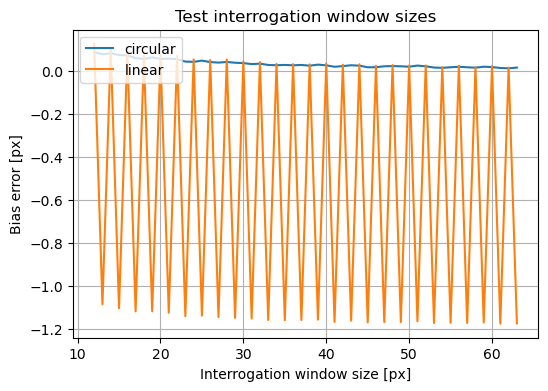

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

legend = []

ax.set_title('Test interrogation window sizes')
ax.set_ylabel('Bias error [px]')
ax.set_xlabel('Interrogation window size [px]')
ax.grid(True)


for err_key in ["circular", "linear"]:
    arr = np.array(errors[err_key])
    ax.plot(np.array(errors["windows"]), arr)
    legend.append(err_key)

ax.legend(
    legend,
    ncol = 1,
    loc = 'upper left'
)

'''
plt.savefig(
    'openpiv_int_window_test.jpeg',
    dpi = 300
)
#'''

In [14]:
def run_test():
    from openpiv import pyprocess as proc
    from openpiv import tools as piv_tls
    from scipy import fft
    
    def fft_correlate_images(image_a, image_b,
                         correlation_method="circular",
                         normalized_correlation=True,
                         conj = np.conj,
                         rfft2 = fft.rfft2,
                         irfft2 = fft.irfft2,
                         fftshift = fft.fftshift):

        if normalized_correlation:
            # remove the effect of stronger laser or
            # longer exposure for frame B
            # image_a = match_histograms(image_a, image_b)

            # remove mean background, normalize to 0..1 range
            image_a = proc.normalize_intensity(image_a)
            image_b = proc.normalize_intensity(image_b)

        s1 = np.array(image_a.shape[-2:])
        s2 = np.array(image_b.shape[-2:])

        if correlation_method == "linear":
            # have to be normalized, mainly because of zero padding
            size = s1 + s2 - 1
            fsize = 2 ** np.ceil(np.log2(size)).astype(int) - 1
            fslice = (slice(0, image_a.shape[0]),
                      slice((fsize[0]-s1[0])//2, (fsize[0]+s1[0])//2),
                      slice((fsize[1]-s1[1])//2, (fsize[1]+s1[1])//2))
            f2a = conj(rfft2(image_a, fsize, axes=(-2, -1)))
            f2b = rfft2(image_b, fsize, axes=(-2, -1))
            corr = fftshift(irfft2(f2a * f2b).real, axes=(-2, -1))[fslice]
        elif correlation_method == "circular":
            f2a = conj(rfft2(image_a))
            f2b = rfft2(image_b)
            corr = fftshift(irfft2(f2a * f2b).real, axes=(-2, -1))
        else:
            print("method is not implemented!")

        if normalized_correlation:
            corr = corr/(s2[0]*s2[1])  # for extended search area
            corr = np.clip(corr, 0, 1)
        return corr
    
    errors = {
        "windows":  [],
        "circular": [],
        "linear":   []
    }
    
    corr_methods = [
        "circular",
        "linear"
    ]
    
    real_disp = 1.5

    file = "test_{}.bmp"

    frame_a = piv_tls.imread(file.format('a'))
    frame_b = piv_tls.imread(file.format('b'))
        
        
    for i in range(12, 128):    
        window_size = i
        overlap = window_size // 2
        
        errors["windows"].append(window_size)
        
        for method in corr_methods: 
            n_rows, n_cols = proc.get_field_shape(
                frame_a.shape,
                window_size,
                overlap
            )
            
            aa = proc.moving_window_array(
                frame_a, 
                window_size, 
                overlap
            )
            
            bb = proc.moving_window_array(
                frame_b, 
                window_size, 
                overlap
            )
            
            corr = fft_correlate_images(
                aa,
                bb,
                correlation_method=method,
                normalized_correlation=True
            )
            
            u, v = proc.vectorized_correlation_to_displacements(
                corr,
                n_rows,
                n_cols
            )

            err = real_disp - np.nanmean(np.hypot(u, v))
            errors[method].append(err)

    return errors

In [15]:
errors = run_test()

Found 1 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 1 bad peak(s)
Found 1 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)
Found 0 bad peak(s)


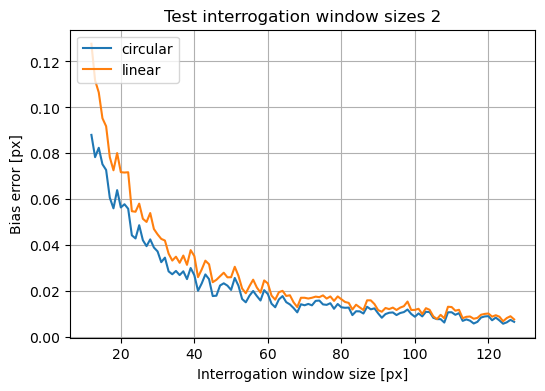

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

legend = []

ax.set_title('Test interrogation window sizes 2')
ax.set_ylabel('Bias error [px]')
ax.set_xlabel('Interrogation window size [px]')
ax.grid(True)


for err_key in ["circular", "linear"]:
    arr = np.array(errors[err_key])
    ax.plot(np.array(errors["windows"]), arr)
    legend.append(err_key)

ax.legend(
    legend,
    ncol = 1,
    loc = 'upper left'
)

#'''
plt.savefig(
    'possible_fix.jpeg',
    dpi = 300
)
#'''

Results are the same even for two different synthetic image pairs.